In [1]:
import numpy as np
import os
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split
#from sklearn.pipeline import Pipeline
#from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, classification_report

import tensorflow as tf
from tensorflow import keras

In [2]:
def Create_Data_Matrix(directory):
    i=0
    for file in os.listdir(directory):
        filename = directory+'/'+file

        # Loads image, converts to grayscale and resizes it to a 300x300 image
        y = np.array(Image.open(filename).convert('RGB').resize((300,300)))

        #Resizes 300x300 image to 90,000x1 array
        col_y = y.ravel()[:,np.newaxis]

        # Saves
        if i==0:
            data = col_y
            #data = y
        else:
            data = np.hstack((data, col_y))
            #data = np.hstack((data, y))

        # Plots image
        """
        plt.figure(figsize=(5,5))
        plt.imshow(y, cmap='gray')
        plt.xticks([]),plt.yticks([])
        plt.show();
        """
        i+=1
        
    return data

In [3]:
def Resize_Before_Training(flattened):
    i = 0
    for x in flattened:
        temp = x.reshape((1,300,300,3))
    
        if i < 10:    
            plt.figure(figsize=(5,5))
            plt.imshow(temp[0], cmap='gray') # temp[0] to actually get img
            plt.xticks([]),plt.yticks([])
            plt.show();
    
        if i == 0:
            data = temp
        else:
            data = np.vstack((data,temp))
    
        i+=1
    
    return data
    

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
"""Creating the data matrix (ON HIPER-GATOR)"""

lighter_pics_HP = r"../../ExperimentPicsCollection/webCam/lighterImages"
lighter_pics2_HP = r"../../ExperimentPicsCollection/webCam/lighterImages2"
emptyClass_pics_HP = r"../../ExperimentPicsCollection/webCam/empty"


lighter_array = Create_Data_Matrix(lighter_pics_HP)
lighter_array2 = Create_Data_Matrix(lighter_pics2_HP)
emptyClass_array = Create_Data_Matrix(emptyClass_pics_HP)



In [6]:

print("lighter array size:",lighter_array.shape)
print("lighter array2 size:",lighter_array2.shape)
print("empty class array size",emptyClass_array.shape)


lighter array size: (270000, 152)
lighter array2 size: (270000, 77)
empty class array size (270000, 271)


In [7]:
lighter_together = np.hstack((lighter_array, lighter_array2))
lighter_together.shape

(270000, 229)

In [8]:
"""X : FEATURE MATRIX For CLASSIFICATION""" 

# stack all arrays together
X = np.hstack((lighter_together,emptyClass_array)).T

X.shape

(500, 270000)

In [9]:
t = np.hstack(( 1*np.ones(lighter_together.shape[1]),np.zeros(emptyClass_array.shape[1]))).T

t.shape

(500,)

In [10]:
"""Train Test Split for Feature Matrix"""
#X =X/255.
 
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, random_state=42, stratify=t)

X_train.shape, X_test.shape, t_train.shape, t_test.shape

((400, 270000), (100, 270000), (400,), (100,))

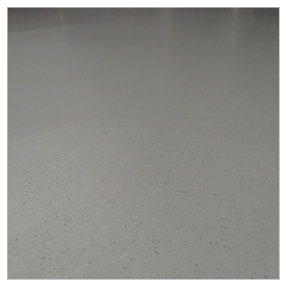

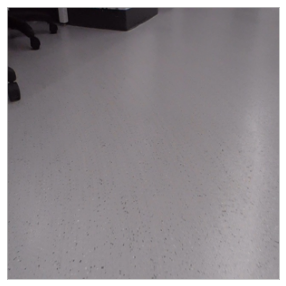

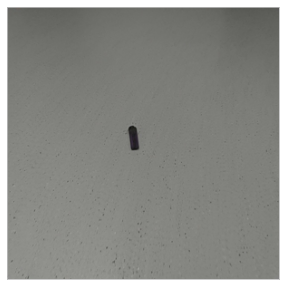

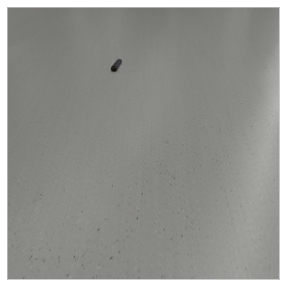

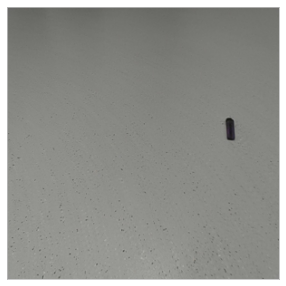

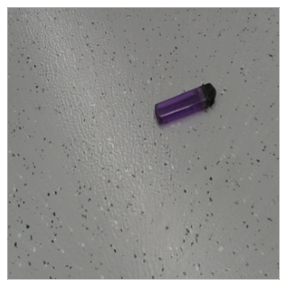

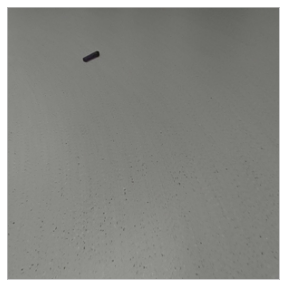

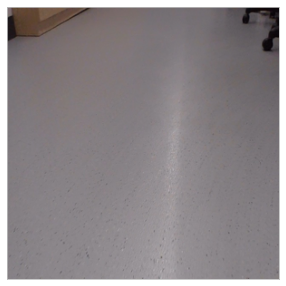

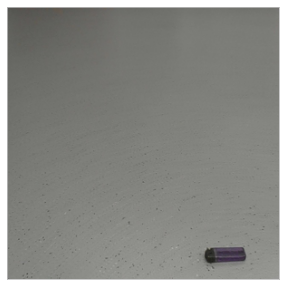

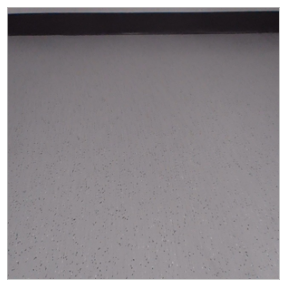

In [11]:
X_train_R = Resize_Before_Training(X_train)

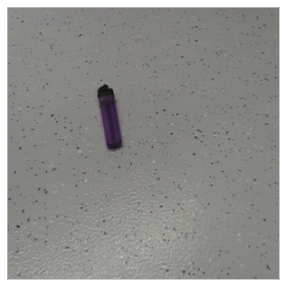

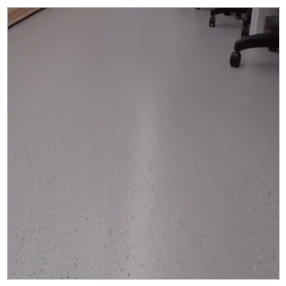

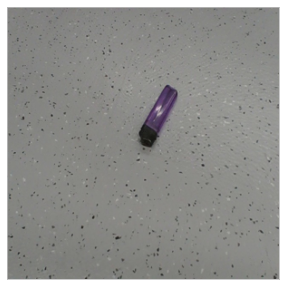

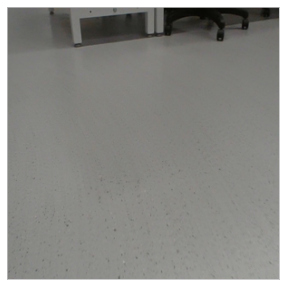

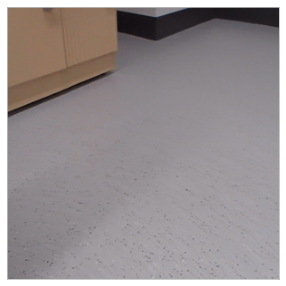

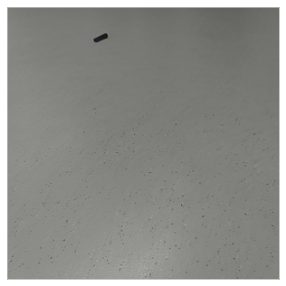

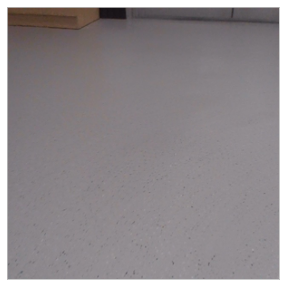

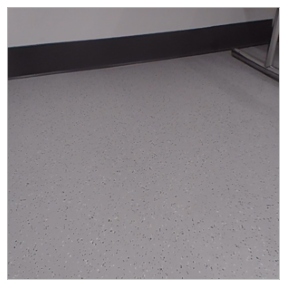

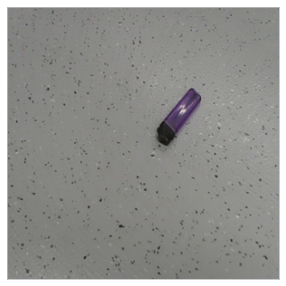

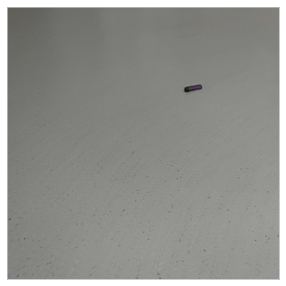

In [12]:
X_test_R = Resize_Before_Training(X_test)

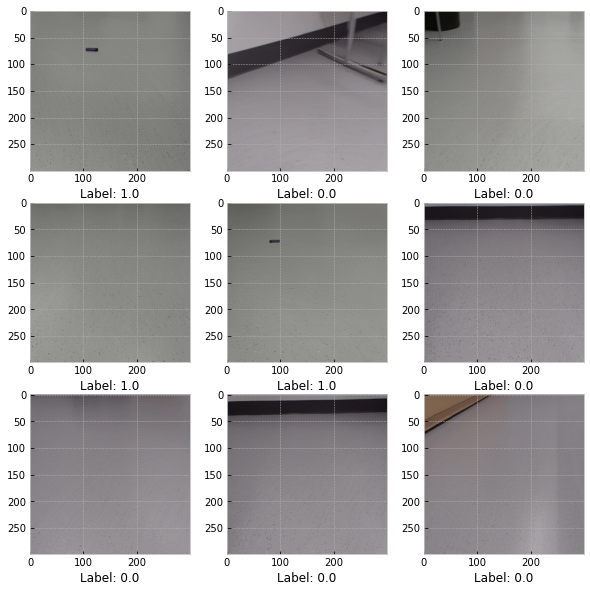

In [13]:
plt.figure(figsize=(10, 10))
index = 10
for i in range(9):
    #augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test_R[index + i].astype("uint8"))
    plt.xlabel("Label: "+ str(t_test[index + i]) )
    #plt.axis("off")

In [14]:
img_height = 300
img_width = 300
batch_size = 32

In [15]:
data_augmentation = keras.Sequential(
  [
    keras.layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,img_width,3)),
    keras.layers.RandomRotation(factor=0.15),
    keras.layers.RandomZoom(height_factor=0.1),
    keras.layers.RandomContrast((0.3,0.1))
    
  ]
)

2023-10-30 16:21:24.441765: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 16:21:25.329869: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0


In [16]:
model = keras.models.Sequential([
    data_augmentation,
    keras.layers.Rescaling(1./255),
    #keras.layers.Conv2D(4, 7, activation='relu', padding='same' , input_shape=[300, 300, 3]), 
    keras.layers.Conv2D(4, 7, activation='relu', padding='same'), 
    keras.layers.MaxPooling2D(2), # experiment to maybe remove
    keras.layers.Conv2D(8, 8, activation='relu', padding='same'), 
    keras.layers.MaxPooling2D(2), 
    keras.layers.Flatten(), # Why do a flatten here? Need to flatne back to 1-D MLP layer?
    # starting MLP layer
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(2, activation='softmax')  #3 classes, get rid of softmax?( output function maybe want 0,1,2?)
])

In [17]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,   
             optimizer=keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

In [18]:
epochs = 100

history = model.fit(X_train_R, t_train, epochs=epochs, batch_size=32,
         validation_data=(X_test_R, t_test)) 

Epoch 1/100


2023-10-30 16:21:27.524374: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2023-10-30 16:21:29.240235: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


13/13 [==============================] - 4s 31ms/step - loss: 1.4818 - accuracy: 0.4975 - val_loss: 0.6950 - val_accuracy: 0.4600
Epoch 2/100
13/13 [==============================] - 0s 14ms/step - loss: 0.6903 - accuracy: 0.5625 - val_loss: 0.6861 - val_accuracy: 0.7200
Epoch 3/100
13/13 [==============================] - 0s 14ms/step - loss: 0.6932 - accuracy: 0.6225 - val_loss: 0.6903 - val_accuracy: 0.5400
Epoch 4/100
13/13 [==============================] - 0s 14ms/step - loss: 0.6872 - accuracy: 0.5425 - val_loss: 0.6807 - val_accuracy: 0.5400
Epoch 5/100
13/13 [==============================] - 0s 14ms/step - loss: 0.6809 - accuracy: 0.5475 - val_loss: 0.6732 - val_accuracy: 0.5400
Epoch 6/100
13/13 [==============================] - 0s 14ms/step - loss: 0.6760 - accuracy: 0.5425 - val_loss: 0.6524 - val_accuracy: 0.5400
Epoch 7/100
13/13 [==============================] - 0s 14ms/step - loss: 0.6449 - accuracy: 0.5525 - val_loss: 0.5848 - val_accuracy: 0.7500
Epoch 8/100
13/13 

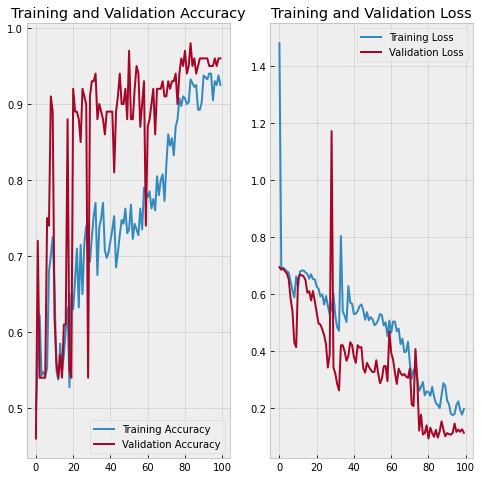

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
y_train = np.argmax(model.predict(X_train_R),axis=1)
y_test = np.argmax(model.predict(X_test_R),axis=1)

In [21]:
print(classification_report(t_train, y_train))

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95       217
         1.0       0.97      0.91      0.94       183

    accuracy                           0.95       400
   macro avg       0.95      0.94      0.95       400
weighted avg       0.95      0.95      0.95       400



In [22]:
print(classification_report(t_test, y_test))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96        54
         1.0       0.98      0.93      0.96        46

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



In [23]:
print(confusion_matrix(t_test, y_test))

[[53  1]
 [ 3 43]]


In [24]:
"""Storing Model in Keras format"""
model.save('webCamPics.keras')